# Create additional variables

## Part 1: Merge individual trial files into one matrix

Loading data from individual files is sometimes slow on the CSCS Piz Daint. Therefore the dataloader was adapted to load in one file containing all trials.

This notebook reads in the individual trial files and saves one larger file which contains all trials. The data is saved in the folder merged_data with the file name corresponding to the variable

In [78]:
import os
if 'notebooks' in os.getcwd():
    os.chdir('../..')  # change to main directory
if 'adrian_sensorium' not in os.getcwd():
    if os.getcwd().split('\\')[-1] == "Petreanu Lab":
        os.chdir('adrian_sensorium')
    else:
        raise FileNotFoundError("The path needs to be fixed")
print('Working directory:', os.getcwd())

Working directory: d:\Python\Anastasia\Petreanu Lab\adrian_sensorium


In [79]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from tqdm.auto import tqdm
import datetime
import scipy as sci
from pathlib import Path

from sensorium.utility.training import set_seed
set_seed(4534)

In [80]:
%matplotlib inline

In [81]:
# folders = sorted( glob.glob( "notebooks/data/static*/") )
# folders

In [82]:
basepath = "notebooks/data/IM_prezipped"
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
# Second level
folders = [os.path.join(folder, name) for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
folders

['notebooks/data/IM_prezipped/LPE10885/2023_10_20']

In [83]:
for folder in folders:
    print('Working on folder: {}'.format(folder), flush=True)

    # find the different data folders with individual files per trial
    subfolders = glob.glob(os.path.join(folder, 'data', '*'))
    subnames = [os.path.basename(f) for f in subfolders]
    # subnames are e.g. ['behavior', 'pupil_center', 'images', 'responses']

    # create new directory if it does not exist
    save_folder = os.path.join(folder, 'merged_data')
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # iterate through all folders, load individual files and save as one large matrix
    for subname in subnames:
        data_folder = os.path.join(folder, 'data', subname)
        nr_files = len(glob.glob(os.path.join(data_folder, '*')))
        shape = np.load(os.path.join(data_folder, '0.npy')).shape
        data = np.empty((nr_files, *shape))

        for nr in tqdm(range(nr_files), desc=subname):
            data[nr] = np.load(os.path.join(data_folder, '{}.npy'.format(nr)))

        # (nr_trials, *) e.g. (5983, 3) for behavior
        data_mat = np.array(data)

        # assert no nans
        assert not np.isnan(data_mat).any(), f'Nans in data_mat {subname}'
        
        np.save(os.path.join(save_folder, '{}.npy'.format(subname)), data_mat)

Working on folder: notebooks/data/IM_prezipped/LPE10885/2023_10_20


behavior:   0%|          | 0/5600 [00:00<?, ?it/s]

images:   0%|          | 0/5600 [00:00<?, ?it/s]

pupil_center:   0%|          | 0/5600 [00:00<?, ?it/s]

responses:   0%|          | 0/5600 [00:00<?, ?it/s]

## Part 2: Extract trial order from timestamps and save

Working on:  notebooks/data/IM_prezipped/LPE10885/2023_10_20


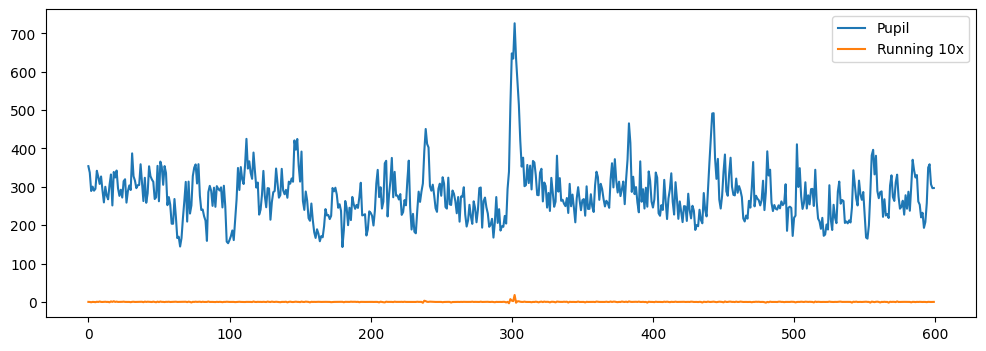

In [84]:
all_sorting = dict()

for folder in folders:
    print('Working on: ', folder)

    # read and sort timestamps
    ts_file = '/meta/trials/frame_trial_ts.npy'
    ts_raw = np.load(os.path.join(folder + ts_file), allow_pickle=True)

    ts = list()
    for string in ts_raw:
        t = datetime.datetime.strptime(string[11:-2], '%Y-%m-%d %H:%M:%S')
        ts.append(t)
    ts = np.array(ts)

    ts_argsort = np.argsort(ts)

    # save the trial_id and sorted_id as .npy arrays in merged_data
    nr_trials = len(ts_argsort)
    trial_id = np.arange(nr_trials, dtype=int)
    # transform to 2d array for batch loader
    trial_id = np.expand_dims(trial_id, axis=1)

    sort_id = np.copy(ts_argsort)
    # transform to 2d array for batch loader
    sort_id = np.expand_dims(sort_id, axis=1)

    # extract rank of each trial. This array maps each trial value to it's position
    # in time. Rank value 2 means that this value occured at time 2
    rank = np.argsort(ts_argsort)  # rank is double argsorted time
    rank_id = np.expand_dims(rank, axis=1)

    np.save(os.path.join(folder, 'merged_data', 'trial_id.npy'), trial_id)
    np.save(os.path.join(folder, 'merged_data', 'sort_id.npy'), sort_id)
    np.save(os.path.join(folder, 'merged_data', 'rank_id.npy'), rank_id)

    # add sorting to dict to save the sorting for all keys together
    # data_key = folder.split("static")[-1].split("-GrayImageNet")[0]
    data_key = f"{folder.split('/')[-2]}-{folder.split('/')[-2]}_{folder.split('/')[-1]}-0"
    all_sorting[data_key] = ts_argsort

    # read in behavior data and sort as sanity check
    behav_file = os.path.join(folder, 'merged_data/behavior.npy')
    behav_data = np.load(behav_file)
    sort_behav = behav_data[ts_argsort]

    plt.figure(figsize=(12, 4))
    plt.plot(sort_behav[0:600, 0], label='Pupil')
    plt.plot(sort_behav[0:600, 2] * 10, label='Running 10x')
    plt.legend()

data_folder = os.path.dirname(folder)  # go back to main data directory
data_folder = Path(data_folder).parents[1]
data_folder = str(data_folder)
np.save(os.path.join(data_folder, 'dataset_sortings.npy'), all_sorting)

## Part 3: Create additional regressors

### First pass the neural activity through model for correct normalization

In [85]:
from nnfabrik.builder import get_data, get_model, get_trainer

In [86]:
# prepare dataloader
# basepath = "notebooks/data/IM_prezipped"
# filenames = [os.path.join(basepath, file)
#              for file in os.listdir(basepath) if ".zip" in file]
# # ensure no Sensorium dataset
# filenames = [file for file in filenames if 'static26872-17-20' not in file]

dataset_fn = 'sensorium.datasets.static_loaders'
dataset_config = {'paths': folders,
                  'normalize': True,
                  'include_behavior': True,
                  'include_eye_position': True,
                  'batch_size': 128,
                  'scale': .25,
                  'preload_from_merged_data': True,
                  'adjusted_normalization': True,  # new normalization for behavior variables
                  'include_trial_id': True,
                  }

dataloaders = get_data(dataset_fn, dataset_config)
dataloaders

OrderedDict([('train',
              OrderedDict([('LPE10885-LPE10885_2023_10_20-0',
                            <torch.utils.data.dataloader.DataLoader at 0x202fe6b28b0>)])),
             ('validation',
              OrderedDict([('LPE10885-LPE10885_2023_10_20-0',
                            <torch.utils.data.dataloader.DataLoader at 0x202fe6b26a0>)])),
             ('test',
              OrderedDict([('LPE10885-LPE10885_2023_10_20-0',
                            <torch.utils.data.dataloader.DataLoader at 0x202fe6b2a00>)])),
             ('final_test',
              OrderedDict([('LPE10885-LPE10885_2023_10_20-0',
                            <torch.utils.data.dataloader.DataLoader at 0x202fe6b2af0>)]))])

In [87]:
# create standard model to pass data through
model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
                'stack': -1,
                'layers': 4,
                'input_kern': 9,
                'gamma_input': 6.3831,
                'gamma_readout': 0.0076,
                'hidden_kern': 7,
                'hidden_channels': 64,
                'depth_separable': True,
                'grid_mean_predictor': {'type': 'cortex',
                                        'input_dimensions': 2,
                                        'hidden_layers': 1,
                                        'hidden_features': 30,
                                        'final_tanh': True},
                'init_sigma': 0.1,
                'init_mu_range': 0.3,
                'gauss_type': 'full',
                'shifter': True,
                }

model = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders,
                  seed=42,)

d:\Python\Anastasia\Petreanu Lab\adrian_sensorium\neuralpredictors\layers\readouts\base.py:72: UserWarning: Use of 'gamma_readout' is deprecated. Please consider using the readout's feature-regularization parameter instead
  warnings.warn(
d:\Python\Anastasia\Petreanu Lab\adrian_sensorium\neuralpredictors\layers\readouts\base.py:88: UserWarning: Readout is NOT initialized with mean activity but with 0!
  warnings.warn("Readout is NOT initialized with mean activity but with 0!")


In [88]:
# get all data from dataloader and model after passing normalization

from sensorium.utility import prediction   # new code

# calculate predictions per dataloader
results = prediction.all_predictions_with_trial(model, dataloaders)

# merge predictions, sort in time and add behavioral variables
merged = prediction.merge_predictions(results)
sorted_res = prediction.sort_predictions_by_time(merged)
prediction.inplace_add_behavior_to_sorted_predictions(sorted_res)

# sorted_res is dictionary with keys of datasets
# each value contains a dictionary with these keys:
# ['target', 'output', 'trial_type', 'trial_id', 'pupil', 'pupil_dt', 'running', 'center']
# the target value is the normalized activity of the neurons

# remove the variable output, because model has not learned anything
for key in sorted_res:
    sorted_res[key]['output'] = None

# save this dictionary
np.save('notebooks/data/sorted_activity_after_dataloader.npy', sorted_res)

Iterating datasets: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


### Regressor with history of neural activity

In [89]:
# Helper functions
# TODO: move to script

def create_recurrent_regressor(activity, trial_tier, lag):
    """ Create causal recurrent regressor which only uses training data points

    Parameters
    ----------
    activity: 2d matrix, (nr_trials, nr_neurons)
        Neural activity sorted by time
    trial_tier: 1d array (nr_trials)
        Contains strings of {'test', 'validation', 'train', 'final_test'} describing trial tier
    lag: int
        Range of frames up to which the history should be averaged

    Returns
    -------
    2d array: (nr_trials, nr_neurons)
        Averaged intensity in the past up to lag

    Adrian 2022-09-30 """

    inds = np.arange(-lag, 0)   # e.g. [-2,-1] for lag 2
    nr_trials = activity.shape[0]
    nr_neurons = activity.shape[1]

    # zero padding at end to map negative indicies in inds to 0
    activity_padded = np.concatenate((activity, np.zeros((lag+1, nr_neurons))))
    history = np.zeros((nr_trials, nr_neurons))

    for i in range(nr_trials):
        # add entry to hist vector
        history[i] = np.mean(activity_padded[inds, :], axis=0)

        # shift hist vector for next entry
        if trial_tier[i] < 2:   # means in train or validation
            # data for this point is available => shifts inds
            inds[0:lag-1] = inds[1:]
            inds[-1] = i
        else:
            # otherwise do nothing, because true value is not available => keep last ones
            pass

    return history


def get_multiple_lags(activity, trial_tier, lags):
    """ Create 3d matrix with different history filters

    Parameters
    ----------
    activity: 2d matrix, (nr_trials, nr_neurons)
        Neural activity sorted by time
    trial_tier: 1d array (nr_trials)
        Contains strings of {'test', 'validation', 'train', 'final_test'} describing trial tier
    lags: list of ints
        Range of frames up to which the history should be averaged

    Returns
    -------
    3d array: (nr_trials, nr_neurons, nr_lags)
        Averaged intensity in the past up to lag

    Adrian 2022-09-30 """

    nr_trials = activity.shape[0]
    nr_neurons = activity.shape[1]

    history_mat = np.zeros((nr_trials, nr_neurons, len(lags)))

    for i, lag in enumerate(lags):
        history_mat[:, :, i] = create_recurrent_regressor(
            activity, trial_tier, lag)

    return history_mat

In [90]:
# load the normalized neural activity from .npy file
data_dict = np.load(
    'notebooks/data/sorted_activity_after_dataloader.npy', allow_pickle=True).item()
keys = list(data_dict.keys())

  0%|          | 0/1 [00:00<?, ?it/s]

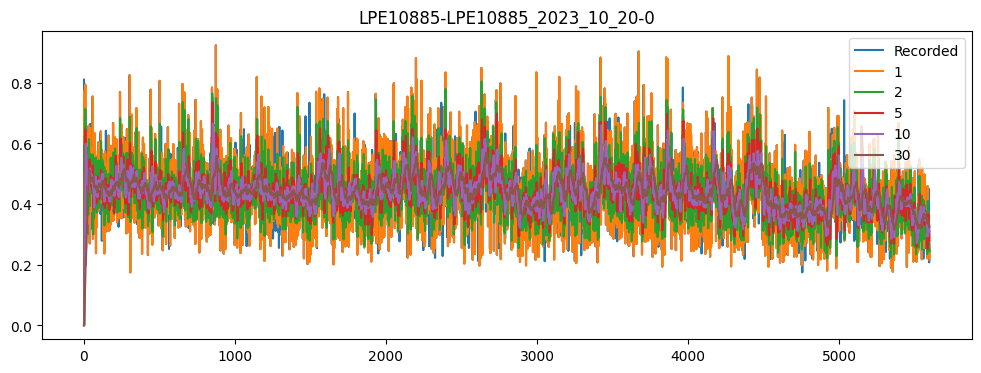

In [91]:
lags = [1, 2, 5, 10, 30]
history = dict()

for key in tqdm(keys):
    # sorted by time
    activity = data_dict[key]['target']   # (nr_trials, nr_neurons)

    # values:  0:train   1:val   2:test   3:final_test
    trial_tier = data_dict[key]['trial_type']    # (nr_trials)

    # trial_id are ids sorted by time
    trial_id = data_dict[key]['trial_id']    # (nr_trials)

    # get history values with different lags
    history_mat = get_multiple_lags(activity, trial_tier, lags)

    # for sanity check of data, plot average with history
    plt.figure(figsize=(12, 4))
    avg = np.mean(activity, axis=1)
    if key == '27204-5-13':  # competition dataset with many 0s
        avg[avg == 0] = np.nan    # replace with nans for nicer plot

    plt.plot(avg, label='Recorded')
    plt.title(key)

    for i, lag in enumerate(lags):
        plt.plot(np.mean(history_mat[:, :, i], axis=1), label=str(lag))
    plt.legend(loc='upper right')
    plt.show()

    # sort data again according to trial_id numbering of data

    # shape: (nr_trials, nr_neurons, nr_lags)
    reordered_history = np.zeros_like(history_mat)
    for i, id_ in enumerate(trial_id):
        reordered_history[id_] = history_mat[i]

    # save matrix
    # before = 'static'
    # after = '-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
    merged_folder = f"notebooks/data/IM_prezipped/{key.split('-')[0]}/{'_'.join(key.split('-')[1].split('_')[1:])}/merged_data"
    # np.save( 'notebooks/data/' + before+key+after + '/merged_data/history.npy', reordered_history)
    np.save(f"{merged_folder}/history.npy", reordered_history)

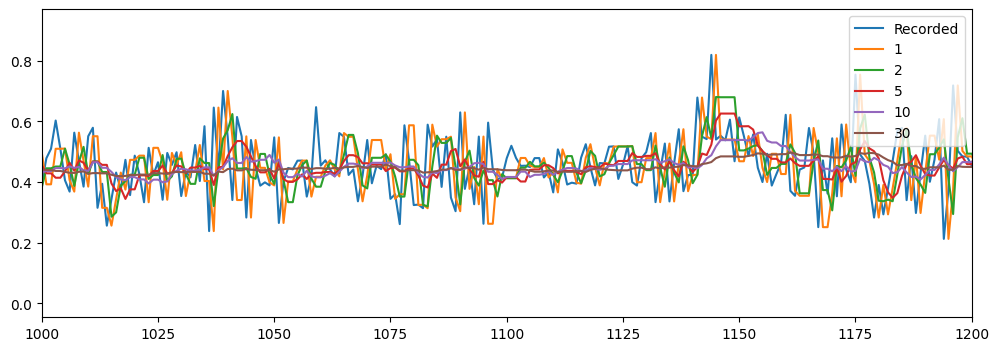

In [92]:
plt.figure(figsize=(12, 4))
plt.plot(avg, label='Recorded')

for i, lag in enumerate(lags):
    plt.plot(np.mean(history_mat[:, :, i], axis=1), label=str(lag))
plt.legend(loc='upper right')
plt.xlim(1000, 1200)
plt.show()

## Regressor with behavioral state
The stimulus changes on every datapoint, but the behavioral state can be more longlasting.

To extract the dimensions of the behavioral state, independent of the stimulus, I am therefore calculating the reduced-rank regression between the neural activity at time t and t+1. This dimension should by experimental design not contain any stimulus information, but only information which is shared across time and is therefore stimulus independent.

The reconstruction of the behavior-only subspace is then passed through a non-negative matrix factorisation, to get latent factors which are sparser and only positive.

In [93]:
# Helper functions
def extract_response_t_and_t_plus_one(activity, trial_type):
    """ Get matrix with available pairs of t and t+1

    Parameters
    ----------
    activity: 2d matrix, (nr_trials, nr_neurons)
        Neural activity sorted by time
    trial_type: 1d array (nr_trials)
        Contains int that describing trial tier
        0:train   1:val   2:test   3:final_test

    Returns
    -------
    2d array: (nr_trial_pairs, nr_neurons)
        Neural activity at matched timepoints t
    2d array: (nr_trial_pairs, nr_neurons)
        Neural activity at matched timepoints t+1

    Adrian 2022-10-03 """

    t_list = list()
    t_one_list = list()

    # find pairs of t and t+1 that are both in the training data
    for i in range(1, len(trial_type)):
        if (trial_type[i-1] < 2) and (trial_type[i-1] < 2):
            t_list.append(i-1)
            t_one_list.append(i)

    activity_t = activity[t_list, :]
    activity_t_one = activity[t_one_list, :]

    return activity_t, activity_t_one


def rrvar(data_t, data_t_one, rank, maxiter=100):
    """Reduced-rank VAR algorithm to predict next timepoint in matrix

    data_t: 2d matrix (nr_trials, nr_features)

    Function based on code by Xinyu Chen
    https://towardsdatascience.com/reduced-rank-vector-autoregressive-model-for-high-dimensional-time-series-forecasting-bdd17df6c5ab
    """
    from tqdm.auto import tqdm

    N = data_t.shape[1]   # number of features
    X1 = data_t.T  # change to (nr_features, nr_trials)
    X2 = data_t_one.T

    V = np.random.randn(rank, N)
    for it in tqdm(range(maxiter)):
        W = X2 @ np.linalg.pinv(V @ X1)
        V = np.linalg.pinv(W) @ X2 @ np.linalg.pinv(X1)

    return W, V

  0%|          | 0/100 [00:00<?, ?it/s]

d:\anaconda3\envs\molanalysis\lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


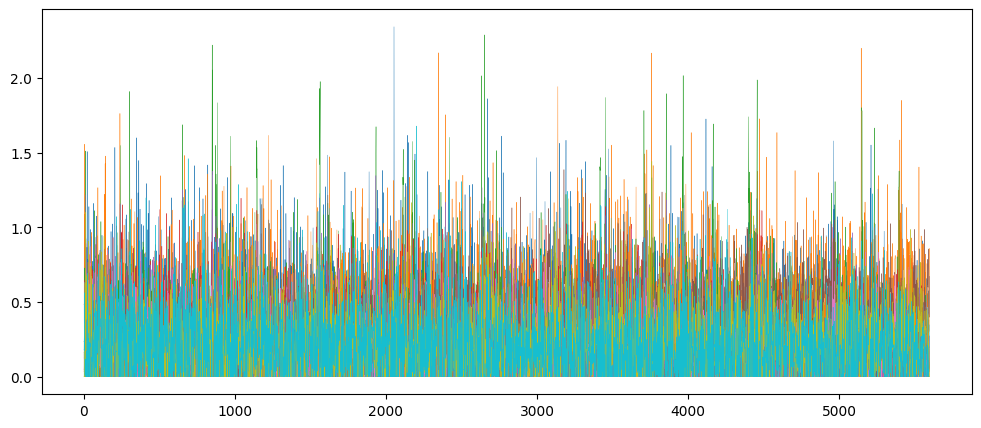

In [94]:
for key in keys:

    # sorted by time
    activity = data_dict[key]['target']   # (nr_trials, nr_neurons)
    # values:  0:train   1:val   2:test   3:final_test
    trial_tier = data_dict[key]['trial_type']    # (nr_trials)
    # trial_id are ids sorted by time
    trial_id = data_dict[key]['trial_id']    # (nr_trials)

    # get trial pairs that are in the training dataset (nr_trial, neurons)
    data_t, data_t_one = extract_response_t_and_t_plus_one(
        activity, trial_tier)

    data_t = np.sqrt(data_t + 1e-6)  # make sure positive values only
    data_t_one = np.sqrt(data_t_one + 1e-6)

    # first PCA to reduce runtime of reduced rank regression
    from sklearn.decomposition import PCA
    pca = PCA(n_components=500)
    pca.fit(data_t)
    t_pca = pca.transform(data_t)    # (trials, n_components)
    t_one_pca = pca.transform(data_t_one)

    # calculate embedding matricies for reduced-rank autoregression
    # extract projection that helps to predict next timepoint
    W, V = rrvar(t_pca, t_one_pca, rank=20)
    rr_embedding = V @ t_pca.T  # output: (rank, nr_trials_train)

    # now project back into neuron space
    restored = pca.inverse_transform((W @ rr_embedding).T)
    restored[restored < 0] = 0  # make positive
    # use non-negative matrix factorization to get sparser+positive values
    from sklearn.decomposition import NMF
    nmf = NMF(n_components=10, init='random', random_state=674, max_iter=1000)
    nmf.fit(restored)

    # now pass the data for each trial (which can contain repeats) through same embedding
    history_lag_one = create_recurrent_regressor(activity, trial_tier, lag=1)

    # output: (rank, nr_trials)
    rr_embedding = V @ pca.transform(history_lag_one).T
    # now project back into neuron space
    restored = pca.inverse_transform((W @ rr_embedding).T)
    restored[restored < 0] = 0  # make positive
    nmf_embedding = nmf.transform(restored)

    # plot saved regressors
    plt.figure(figsize=(12, 5))
    _ = plt.plot(nmf_embedding, lw=0.3)
    plt.show()

    # change order of datapoint from time sorting to trial_ids
    reordered_nmf = np.zeros_like(nmf_embedding)
    for i, id_ in enumerate(trial_id):
        reordered_nmf[id_] = nmf_embedding[i]

    # save matrix
    # before = 'static'
    # after = '-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
    # np.save('notebooks/data/' + before+key+after +
    #         '/merged_data/state.npy', reordered_nmf)
    merged_folder = f"notebooks/data/IM_prezipped/{key.split('-')[0]}/{'_'.join(key.split('-')[1].split('_')[1:])}/merged_data"
    np.save(f"{merged_folder}/state.npy", reordered_nmf)